In [1]:
# TImeSeriesTransformerConfig Sample

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Initializing a Time Series Transformer configuration with 12 time steps for prediction

config = TimeSeriesTransformerConfig(prediction_length=12)

model = TimeSeriesTransformerModel(config)

model.config

TimeSeriesTransformerConfig {
  "_attn_implementation_autoset": true,
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    0
  ],
  "context_length": 12,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 9,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 0,
  "prediction_length": 12,
  "scaling": "mean",
  "transformers_version

In [6]:
# 샘플 코드

from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerForPrediction

# 허깅페이스 허브에서 데이터셋 파일을 다운로드합니다.
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch",  # 데이터셋의 저장소 ID
    filename="train-batch.pt",  # 다운로드할 파일 이름
    repo_type="dataset"  # 저장소 유형을 데이터셋으로 지정
)

# 다운로드한 파일을 PyTorch 텐서로 로드합니다.
batch = torch.load(file)

# 사전 학습된 시계열 트랜스포머 모델을 불러옵니다.
model = TimeSeriesTransformerForPrediction.from_pretrained(
    "huggingface/time-series-transformer-tourism-monthly"  # 모델의 경로
)

# 훈련 중에는 과거 및 미래 값과 추가적인 특징들을 모델에 제공합니다.
outputs = model(
    past_values=batch["past_values"],  # 과거 시계열 값
    past_time_features=batch["past_time_features"],  # 과거 시간적 특징
    past_observed_mask=batch["past_observed_mask"],  # 관측된 과거 값의 마스크
    static_categorical_features=batch["static_categorical_features"],  # 정적 범주형 특징
    static_real_features=batch["static_real_features"],  # 정적 실수형 특징
    future_values=batch["future_values"],  # 미래 시계열 값
    future_time_features=batch["future_time_features"],  # 미래 시간적 특징
)

# 모델의 손실을 계산하고 역전파를 수행합니다.
loss = outputs.loss
loss.backward()

# 추론 시에는 과거 값과 추가적인 특징들만 제공합니다.
# 모델은 자동회귀적으로 미래 값을 생성합니다.
outputs = model.generate(
    past_values=batch["past_values"],  # 과거 시계열 값
    past_time_features=batch["past_time_features"],  # 과거 시간적 특징
    past_observed_mask=batch["past_observed_mask"],  # 관측된 과거 값의 마스크
    static_categorical_features=batch["static_categorical_features"],  # 정적 범주형 특징
    static_real_features=batch["static_real_features"],  # 정적 실수형 특징
    future_time_features=batch["future_time_features"],  # 미래 시간적 특징
)

# 생성된 시계열 예측의 평균을 계산합니다.
mean_prediction = outputs.sequences.mean(dim=1)

/tmp/ipykernel_2947421/27703566.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch = torch.load(file)


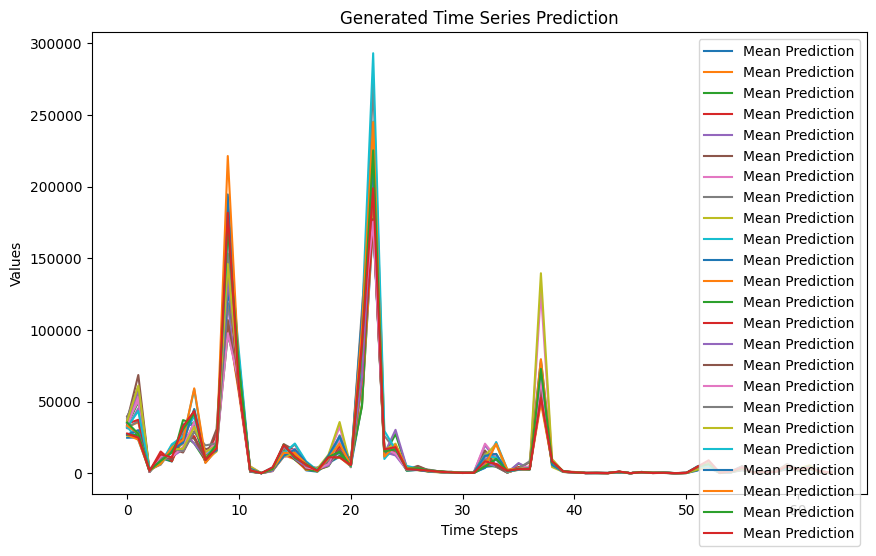

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mean_prediction.numpy(), label='Mean Prediction')
plt.title('Generated Time Series Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

In [8]:
# 생성된 시계열 예측의 평균 절대 오차(MAE)를 계산합니다.
from sklearn.metrics import mean_absolute_error

# 실제 미래 값과 예측된 미래 값의 평균 절대 오차를 계산합니다.
mae = mean_absolute_error(batch["future_values"].numpy(), mean_prediction.numpy())
print(f"Mean Absolute Error (MAE): {mae}")

# 생성된 시계열 예측의 평균 제곱 오차(MSE)를 계산합니다.
from sklearn.metrics import mean_squared_error

# 실제 미래 값과 예측된 미래 값의 평균 제곱 오차를 계산합니다.
mse = mean_squared_error(batch["future_values"].numpy(), mean_prediction.numpy())
print(f"Mean Squared Error (MSE): {mse}")

# 생성된 시계열 예측의 결정 계수(R^2)를 계산합니다.
from sklearn.metrics import r2_score

# 실제 미래 값과 예측된 미래 값의 결정 계수를 계산합니다.
r2 = r2_score(batch["future_values"].numpy(), mean_prediction.numpy())
print(f"R^2 Score: {r2}")


Mean Absolute Error (MAE): 1818.91650390625
Mean Squared Error (MSE): 28404058.0
R^2 Score: 0.9737868309020996
